# Predictive Maintenance in PySpark


La maintenance prédictive est un sujet crucial dans l'industrie pour prévoir l'état des actifs afin d'éviter les arrêts de production et les défaillances. pour prévoir l'état des actifs afin d'éviter les arrêts de production et les défaillances. Cet ensemble de données est une version Kaggle du célèbre jeu de données public de modélisation de la dégradation des actifs de la NASA. Il contient des données simulées de Run-to-Failure (fonctionnement jusqu'à la défaillance) provenant de moteurs à réaction turbofan.
Cet ensemble de données est disponible publiquement et peut être téléchargé via ce  [lien](https://www.kaggle.com/datasets/behrad3d/nasa-cmaps)

La simulation de dégradation du moteur a été réalisée à l'aide du logiciel C-MAPSS (Commercial Modular Aero-Propulsion System Simulation). Quatre ensembles distincts ont été simulés sous différentes combinaisons de conditions opérationnelles et de modes de panne. Plusieurs canaux de capteurs ont été enregistrés pour caractériser l'évolution des défaillances. L'ensemble de données a été fourni par le Prognostics Center of Excellence (CoE) de la NASA Ames Research Center.

***Objectif de la prédiction***
L'objectif est de prédire la durée de vie restante (RUL - Remaining Useful Life) de chaque moteur dans l'ensemble de test. La RUL correspond au nombre de cycles restants avant la défaillance complète du moteur après le dernier point de données de l'ensemble de test.

## Importer les bibliothèques 

In [1]:
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DoubleType
import kagglehub
import os

c:\Users\Slash\anaconda3\envs\new_pyspark_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# updater tjrs les path de python car ca ne marche pas manuallement
os.environ['PYSPARK_PYTHON'] = r"C:\Users\Slash\anaconda3\envs\new_pyspark_env\python.exe"
os.environ['PYSPARK_DRIVER_PYTHON'] = r"C:\Users\Slash\anaconda3\envs\new_pyspark_env\python.exe"
# check les paths
print("PYSPARK_PYTHON:", os.environ.get('PYSPARK_PYTHON'))
print("PYSPARK_DRIVER_PYTHON:", os.environ.get('PYSPARK_DRIVER_PYTHON'))


PYSPARK_PYTHON: C:\Users\Slash\anaconda3\envs\new_pyspark_env\python.exe
PYSPARK_DRIVER_PYTHON: C:\Users\Slash\anaconda3\envs\new_pyspark_env\python.exe


## Dataset

In [41]:
path = kagglehub.dataset_download("behrad3d/nasa-cmaps")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Slash\.cache\kagglehub\datasets\behrad3d\nasa-cmaps\versions\1


### Initialiser SparkSession

In [42]:
spark = SparkSession.builder \
       .master("local") \
       .appName('NasaRULprediction') \
       .config("spark.executorEnv.PYSPARK_PYTHON", r"C:\Users\Slash\anaconda3\envs\pyspark-env\python.exe") \
      .config("spark.executorEnv.PYSPARK_DRIVER_PYTHON", r"C:\Users\Slash\anaconda3\envs\pyspark-env\python.exe") \
       .getOrCreate()

sc = spark.sparkContext
sc.getConf().getAll()

[('spark.master', 'local'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.executorEnv.PYSPARK_PYTHON',
  'C:\\Users\\Slash\\anaconda3\\envs\

In [43]:
os.listdir(path)

['CMaps']

In [44]:
def Convertir_data_rdd(sc, path, files_list, sep):
    rdd = sc.union([sc.textFile(path + f) for f in files_list])
    rdd = rdd.map(lambda line: line.split(sep))
    return rdd   

train_files = [filename for filename in os.listdir(path+'\CMaps') if (filename.startswith('train') and filename.endswith('.txt'))]
test_files = [filename for filename in os.listdir(path+'\CMaps') if (filename.startswith('test') and filename.endswith('.txt'))]
train_files,test_files

(['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt'],
 ['test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt'])

In [45]:
[train_files[0]]

['train_FD001.txt']

In [46]:
train_rdd = Convertir_data_rdd(sc, path+"\CMaps\\", [train_files[0]], " ")
test_rdd = Convertir_data_rdd(sc, path+"\CMaps\\", [test_files[0]], " ")

train_rdd,test_rdd


(PythonRDD[553] at RDD at PythonRDD.scala:53,
 PythonRDD[554] at RDD at PythonRDD.scala:53)

In [47]:
header = [ "engine","cycle_time", "operational_set_1", "operational_set_2","operational_set_3", 'sensor1',
       'sensor2', 'sensor3', 'sensor4', 'sensor5', 'sensor6', 'sensor7',
       'sensor8', 'sensor9', 'sensor10', 'sensor11', 'sensor12', 'sensor13',
       'sensor14', 'sensor15', 'sensor16', 'sensor17', 'sensor18', 'sensor19',
       'sensor20', 'sensor21' ]
          
          

train_df = train_rdd.toDF(header).drop("_27").drop("_28")
test_df  = test_rdd.toDF(header).drop("_27").drop("_28")

In [48]:
(train_df.count(), len(train_df.columns)),(test_df.count(), len(test_df.columns))

((20631, 26), (13096, 26))

In [49]:
train_df.show(truncate=False)

+------+----------+-----------------+-----------------+-----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|engine|cycle_time|operational_set_1|operational_set_2|operational_set_3|sensor1|sensor2|sensor3|sensor4|sensor5|sensor6|sensor7|sensor8|sensor9|sensor10|sensor11|sensor12|sensor13|sensor14|sensor15|sensor16|sensor17|sensor18|sensor19|sensor20|sensor21|
+------+----------+-----------------+-----------------+-----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|1     |1         |-0.0007          |-0.0004          |100.0            |518.67 |641.82 |1589.70|1400.60|14.62  |21.61  |554.36 |2388.06|9046.19|1.30    |47.47   |521.66  |2388.02 |8138.62 |8.4195  |0.03    |392     |2388    |100.00  |39.

###  pré-traitement des données

In [50]:
train_df.printSchema()

root
 |-- engine: string (nullable = true)
 |-- cycle_time: string (nullable = true)
 |-- operational_set_1: string (nullable = true)
 |-- operational_set_2: string (nullable = true)
 |-- operational_set_3: string (nullable = true)
 |-- sensor1: string (nullable = true)
 |-- sensor2: string (nullable = true)
 |-- sensor3: string (nullable = true)
 |-- sensor4: string (nullable = true)
 |-- sensor5: string (nullable = true)
 |-- sensor6: string (nullable = true)
 |-- sensor7: string (nullable = true)
 |-- sensor8: string (nullable = true)
 |-- sensor9: string (nullable = true)
 |-- sensor10: string (nullable = true)
 |-- sensor11: string (nullable = true)
 |-- sensor12: string (nullable = true)
 |-- sensor13: string (nullable = true)
 |-- sensor14: string (nullable = true)
 |-- sensor15: string (nullable = true)
 |-- sensor16: string (nullable = true)
 |-- sensor17: string (nullable = true)
 |-- sensor18: string (nullable = true)
 |-- sensor19: string (nullable = true)
 |-- sensor20: st

In [51]:
train_df.describe().show()


+-------+------------------+------------------+--------------------+--------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+--------------------+------------------+-------------------+------------------+-----------------+-------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+--------+--------+-------------------+-------------------+
|summary|            engine|        cycle_time|   operational_set_1|   operational_set_2|operational_set_3|          sensor1|           sensor2|           sensor3|          sensor4|           sensor5|             sensor6|           sensor7|            sensor8|           sensor9|         sensor10|           sensor11|          sensor12|          sensor13|          sensor14|           sensor15|            sensor16|          sensor17|sensor18|sensor19|           sensor20|           sensor21|
+-------+-----

In [14]:
from pyspark.sql.functions import col, isnan, when, count


variables_nulles= train_df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in train_df.columns])
variables_nulles_test= test_df.select([count(when(col(c).isNull() | isnan(c), c)).alias(c) for c in test_df.columns])
print('Valeurs nulles dans chaque colonne :' )
variables_nulles.show()
print('Valeurs nulles dans chaque colonne pour les donnees test :' )
variables_nulles_test.show()

Valeurs nulles dans chaque colonne :
+------+----------+-----------------+-----------------+-----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|engine|cycle_time|operational_set_1|operational_set_2|operational_set_3|sensor1|sensor2|sensor3|sensor4|sensor5|sensor6|sensor7|sensor8|sensor9|sensor10|sensor11|sensor12|sensor13|sensor14|sensor15|sensor16|sensor17|sensor18|sensor19|sensor20|sensor21|
+------+----------+-----------------+-----------------+-----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|     0|         0|                0|                0|                0|      0|      0|      0|      0|      0|      0|      0|      0|      0|       0|       0|       0|       0|       0|       0|  

In [15]:
train_df.groupBy('engine').count().show()

+------+-----+
|engine|count|
+------+-----+
|     7|  259|
|    51|  213|
|    15|  207|
|    54|  257|
|    11|  240|
|    29|  163|
|    69|  362|
|    42|  196|
|    73|  213|
|    87|  178|
|    64|  283|
|     3|  179|
|    30|  194|
|    34|  195|
|    59|  231|
|     8|  150|
|    22|  202|
|    28|  165|
|    85|  188|
|    16|  209|
+------+-----+
only showing top 20 rows



### Création de RUL pour "Train Data" et "Test Data"

Dans cette étape, nous ajoutons des étiquettes de Durée de Vie Restante (Remaining Useful Life - RUL) aux ensembles de données d'entraînement et de test. La Durée de Vie Restante est une estimation du nombre d'unités de temps (dans ce cas c'est les jours) pendant lesquelles la machine peut fonctionner correctement avant de tomber en panne complète.

In [52]:
def add_rul_labeling(df, idx, time):
   
    rul = df.groupBy([idx]).agg({time: "max"}).sort((idx))

    rul = rul.toDF(idx, 'max')

    df = df.join(rul, on=[idx], how= 'left')

    df = df.withColumn('rul', df['max'] - df[time])

    df = df.drop('max')
    
    return df

def add_classfication(df, w1):
   
    df = df.withColumn('classification', F.when(df.rul<=w1,1).otherwise(0))    
    return df


train_df = add_rul_labeling(train_df, 'engine', 'cycle_time')
train_df = add_classfication(train_df,30) # si rul est inferieur a 30 donc il dans la zone Alarm sinon il est dans la zone warning
train_df.show(3)

+------+----------+-----------------+-----------------+-----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+----+--------------+
|engine|cycle_time|operational_set_1|operational_set_2|operational_set_3|sensor1|sensor2|sensor3|sensor4|sensor5|sensor6|sensor7|sensor8|sensor9|sensor10|sensor11|sensor12|sensor13|sensor14|sensor15|sensor16|sensor17|sensor18|sensor19|sensor20|sensor21| rul|classification|
+------+----------+-----------------+-----------------+-----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+----+--------------+
|     7|         1|          -0.0005|           0.0004|            100.0| 518.67| 642.38|1589.49|1395.48|  14.62|  21.61| 554.76|2387.97|9071.27|    1.30|   47.24|  522.19| 2387.

In [53]:
os.listdir(path+'/CMaps') 

['Damage Propagation Modeling.pdf',
 'readme.txt',
 'RUL_FD001.txt',
 'RUL_FD002.txt',
 'RUL_FD003.txt',
 'RUL_FD004.txt',
 'test_FD001.txt',
 'test_FD002.txt',
 'test_FD003.txt',
 'test_FD004.txt',
 'train_FD001.txt',
 'train_FD002.txt',
 'train_FD003.txt',
 'train_FD004.txt',
 'x.txt']

In [54]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

# Étape 1 : Lecture et traitement des données de vérité terrain (RUL)
# Récupérer le fichier qui commencent par "RUL" et les trier
fichier = sorted([filename for filename in os.listdir(path + '\CMaps\\') if filename.startswith("RUL")])
# Convertir le fichier sélectionné en RDD
rdd_gt = Convertir_data_rdd(sc, path+"\CMaps\\", [fichier[0]], " ")

# Transformer le RDD en DataFrame avec une colonne "rul" (Remaining Useful Life)
df_gt = rdd_gt.toDF(["rul"]).select(F.col("rul").cast(IntegerType()))

# Ajouter un identifiant unique ("engine") pour chaque moteur basé sur la colonne "rul"
df_gt = df_gt.withColumn("engine", F.row_number().over(Window.orderBy("rul")))

# Étape 2 : Calculer le RUL total
# Regrouper les données de test par moteur et calculer le cycle maximum pour chaque moteur
rul = test_df.groupBy("engine").agg(F.max("cycle_time").alias("max_cycle_time"))

# Fusionner les données de vérité terrain avec les cycles maximums pour calculer le RUL total
df_gt = df_gt.join(rul, on="engine", how="left").withColumn("total_rul", F.col("rul") + F.col("max_cycle_time"))

# Étape 3 : Ajouter la colonne RUL au DataFrame de test
# Fusionner les données de test avec le RUL total
test_df = test_df.join(df_gt.select("engine", "total_rul"), on="engine", how="left")

# Calculer le RUL pour chaque cycle en soustrayant le temps de cycle du RUL total
test_df = test_df.withColumn("rul", F.col("total_rul") - F.col("cycle_time")).drop("total_rul")

# Étape 4 : Trier les données de test
# Trier les données par moteur et par temps de cycle pour faciliter l'analyse
test_df = test_df.orderBy("engine", "cycle_time")
test_df.show()


+------+----------+-----------------+-----------------+-----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----+
|engine|cycle_time|operational_set_1|operational_set_2|operational_set_3|sensor1|sensor2|sensor3|sensor4|sensor5|sensor6|sensor7|sensor8|sensor9|sensor10|sensor11|sensor12|sensor13|sensor14|sensor15|sensor16|sensor17|sensor18|sensor19|sensor20|sensor21|  rul|
+------+----------+-----------------+-----------------+-----------------+-------+-------+-------+-------+-------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----+
|     1|         1|           0.0023|           0.0003|            100.0| 518.67| 643.02|1585.29|1398.21|  14.62|  21.61| 553.90|2388.04|9050.17|    1.30|   47.20|  521.72| 2388.03| 8125.55|  8.4052|    0.03|     392|   

In [55]:
# Ajouter la classification a test_df
w1 = 30
test_df = add_classfication(test_df,w1)
test_df.select(test_df['engine'], test_df['rul'], test_df['classification']).show(30)

+------+-----+--------------+
|engine|  rul|classification|
+------+-----+--------------+
|     1| 15.0|             1|
|     1|  6.0|             1|
|     1|  5.0|             1|
|     1|  4.0|             1|
|     1|  3.0|             1|
|     1|  2.0|             1|
|     1|  1.0|             1|
|     1|  0.0|             1|
|     1| -1.0|             1|
|     1| -2.0|             1|
|     1| -3.0|             1|
|     1| 14.0|             1|
|     1| -4.0|             1|
|     1| -5.0|             1|
|     1| -6.0|             1|
|     1| -7.0|             1|
|     1| -8.0|             1|
|     1| -9.0|             1|
|     1|-10.0|             1|
|     1|-11.0|             1|
|     1|-12.0|             1|
|     1|-13.0|             1|
|     1| 13.0|             1|
|     1|-14.0|             1|
|     1|-15.0|             1|
|     1| 12.0|             1|
|     1| 11.0|             1|
|     1| 10.0|             1|
|     1|  9.0|             1|
|     1|  8.0|             1|
+------+--

In [20]:
(train_df.count(), len(train_df.columns)),(test_df.count(), len(test_df.columns))

((20631, 28), (13096, 28))

Le type de données est une chaîne de caractères, donc à cette étape, il faut les convertir en double ou integer

In [56]:
train_df.columns

['engine',
 'cycle_time',
 'operational_set_1',
 'operational_set_2',
 'operational_set_3',
 'sensor1',
 'sensor2',
 'sensor3',
 'sensor4',
 'sensor5',
 'sensor6',
 'sensor7',
 'sensor8',
 'sensor9',
 'sensor10',
 'sensor11',
 'sensor12',
 'sensor13',
 'sensor14',
 'sensor15',
 'sensor16',
 'sensor17',
 'sensor18',
 'sensor19',
 'sensor20',
 'sensor21',
 'rul',
 'classification']

In [57]:

def set_df_datatypes(df, int_list=[], dob_list=[]):
    if len(int_list) > 0:
        for f in int_list:
            df = df.withColumn(f, df[f].cast(IntegerType()))
    
    if len(dob_list) > 0:
        for f in dob_list:
            df = df.withColumn(f, df[f].cast(DoubleType()))
    
    return df

int_list= ["engine", "cycle_time","rul","classification"]
double_list = list(set(train_df.columns) - set(int_list))
train_df = set_df_datatypes(train_df, int_list, double_list)
test_df = set_df_datatypes(test_df, int_list, double_list)
train_df.printSchema()

root
 |-- engine: integer (nullable = true)
 |-- cycle_time: integer (nullable = true)
 |-- operational_set_1: double (nullable = true)
 |-- operational_set_2: double (nullable = true)
 |-- operational_set_3: double (nullable = true)
 |-- sensor1: double (nullable = true)
 |-- sensor2: double (nullable = true)
 |-- sensor3: double (nullable = true)
 |-- sensor4: double (nullable = true)
 |-- sensor5: double (nullable = true)
 |-- sensor6: double (nullable = true)
 |-- sensor7: double (nullable = true)
 |-- sensor8: double (nullable = true)
 |-- sensor9: double (nullable = true)
 |-- sensor10: double (nullable = true)
 |-- sensor11: double (nullable = true)
 |-- sensor12: double (nullable = true)
 |-- sensor13: double (nullable = true)
 |-- sensor14: double (nullable = true)
 |-- sensor15: double (nullable = true)
 |-- sensor16: double (nullable = true)
 |-- sensor17: double (nullable = true)
 |-- sensor18: double (nullable = true)
 |-- sensor19: double (nullable = true)
 |-- sensor20: 

## EDA

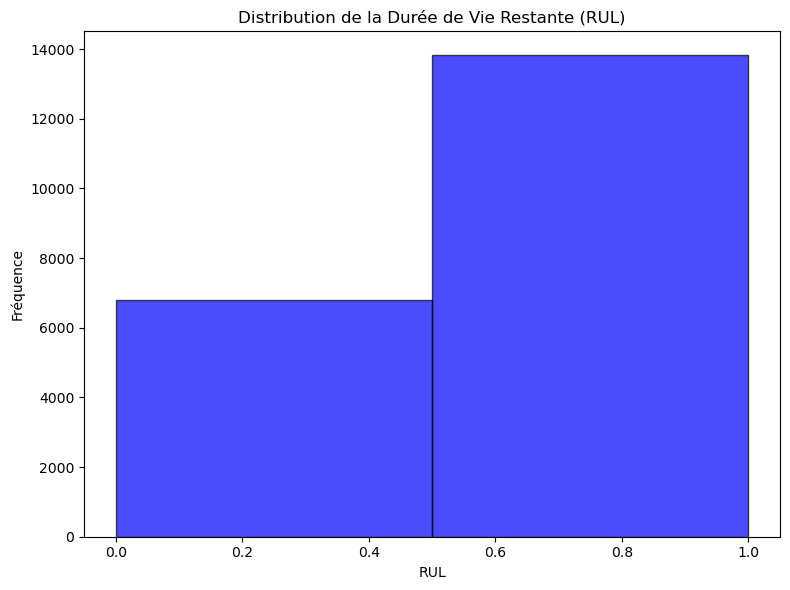

In [ ]:
# Récupérer les données RUL sous forme de liste
classification_values = train_df.select("classification").rdd.flatMap(lambda x: x).collect()

# Tracer l'histogramme de la distribution de RUL
plt.figure(figsize=(8, 6))
plt.hist(classification_values, bins=2, color='blue', edgecolor='black', alpha=0.7)
plt.title("Distribution de la Durée de Vie Restante (RUL)")
plt.xlabel("Classification")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

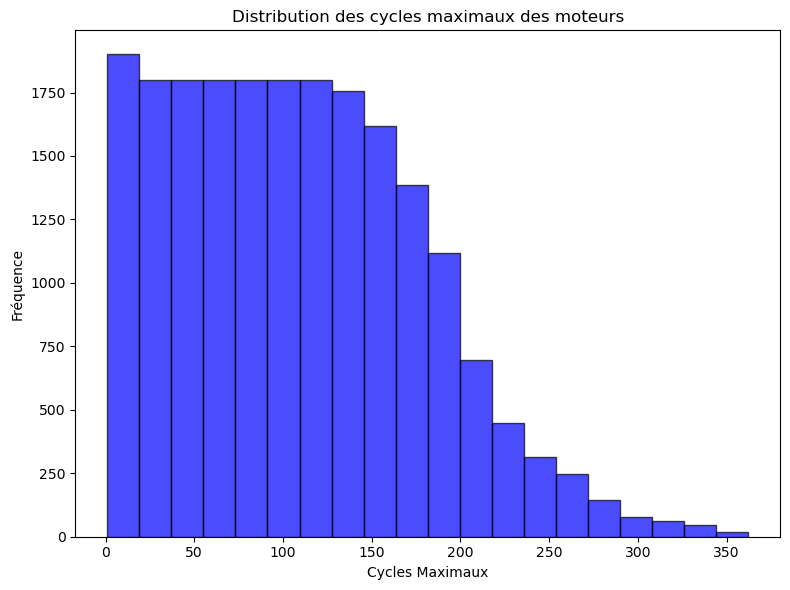

In [25]:
# Visualiser la distribution des cycles maximaux
# Récupérer les données RUL sous forme de liste
cycle_time_values = train_df.select("cycle_time").rdd.flatMap(lambda x: x).collect()

# Tracer l'histogramme de la distribution de RUL
plt.figure(figsize=(8, 6))
plt.hist(cycle_time_values, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title("Distribution des cycles maximaux des moteurs")
plt.xlabel("Cycles Maximaux")
plt.ylabel("Fréquence")
plt.tight_layout()
plt.show()

In [59]:
from pyspark.sql import SparkSession

def get_pandasdf_from_sparkdf(spark_df, view_name, query):
    spark_df.createOrReplaceTempView(view_name)
    return spark.sql(query).toPandas()



def plot_pandas_ts(df, time_feature, start_col_idx, rows, cols, figsize_H, figsize_V):
   
    df.set_index(time_feature) 
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(figsize_H, figsize_V))
    
    for i in range(0,rows):
        for j in range(0,cols):
            
            df[df.iloc[:,start_col_idx].name].plot(ax=axes[i,j]); 
            axes[i,j].set_title(df.iloc[:,start_col_idx].name, fontweight='bold')           
            axes[i,j].set_xlim([0,len(df)])
            start_col_idx+= 1
    
    plt.tight_layout()
   

In [27]:
train_df.printSchema()


root
 |-- engine: integer (nullable = true)
 |-- cycle_time: integer (nullable = true)
 |-- operational_set_1: double (nullable = true)
 |-- operational_set_2: double (nullable = true)
 |-- operational_set_3: double (nullable = true)
 |-- sensor1: double (nullable = true)
 |-- sensor2: double (nullable = true)
 |-- sensor3: double (nullable = true)
 |-- sensor4: double (nullable = true)
 |-- sensor5: double (nullable = true)
 |-- sensor6: double (nullable = true)
 |-- sensor7: double (nullable = true)
 |-- sensor8: double (nullable = true)
 |-- sensor9: double (nullable = true)
 |-- sensor10: double (nullable = true)
 |-- sensor11: double (nullable = true)
 |-- sensor12: double (nullable = true)
 |-- sensor13: double (nullable = true)
 |-- sensor14: double (nullable = true)
 |-- sensor15: double (nullable = true)
 |-- sensor16: double (nullable = true)
 |-- sensor17: double (nullable = true)
 |-- sensor18: double (nullable = true)
 |-- sensor19: double (nullable = true)
 |-- sensor20: 

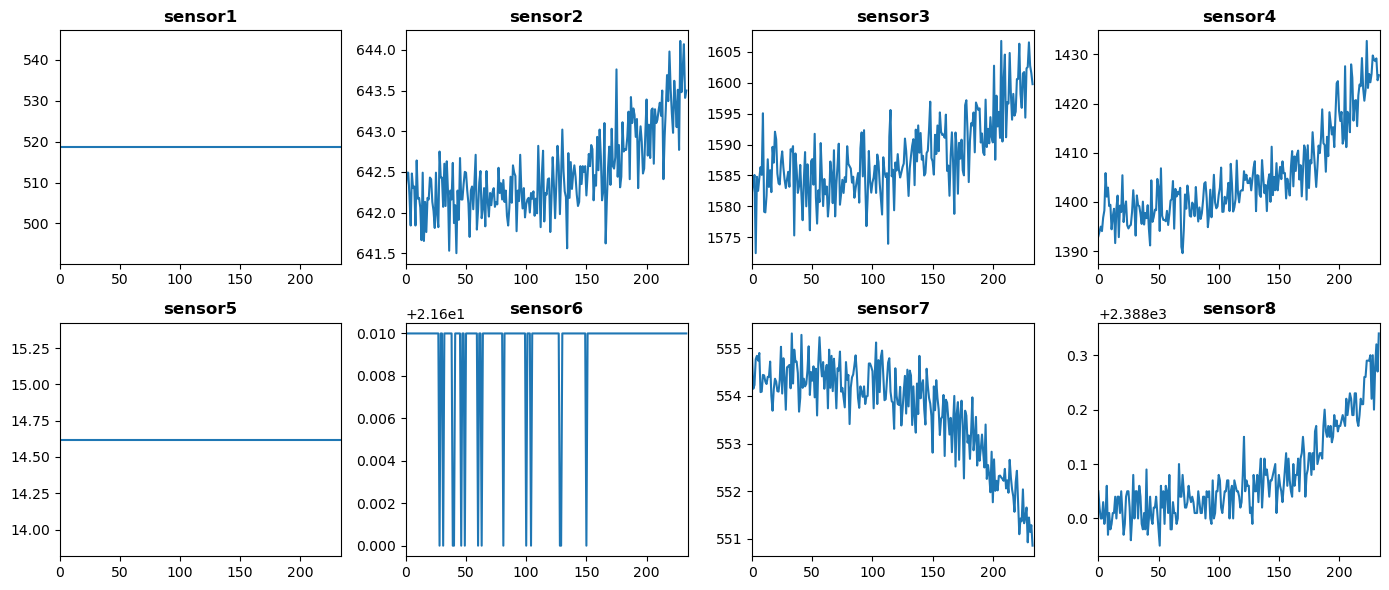

In [28]:
%matplotlib inline
sqlQuery = """
    SELECT  cycle_time, sensor1, sensor2, sensor3, sensor4, sensor5, sensor6, sensor7, sensor8,sensor9,sensor10
    FROM df1 
    WHERE engine =31
    """

plotdata1 = get_pandasdf_from_sparkdf(train_df, "df1", sqlQuery)

plot_pandas_ts(plotdata1, 'cycle_time',  1, 2, 4, 14, 6)

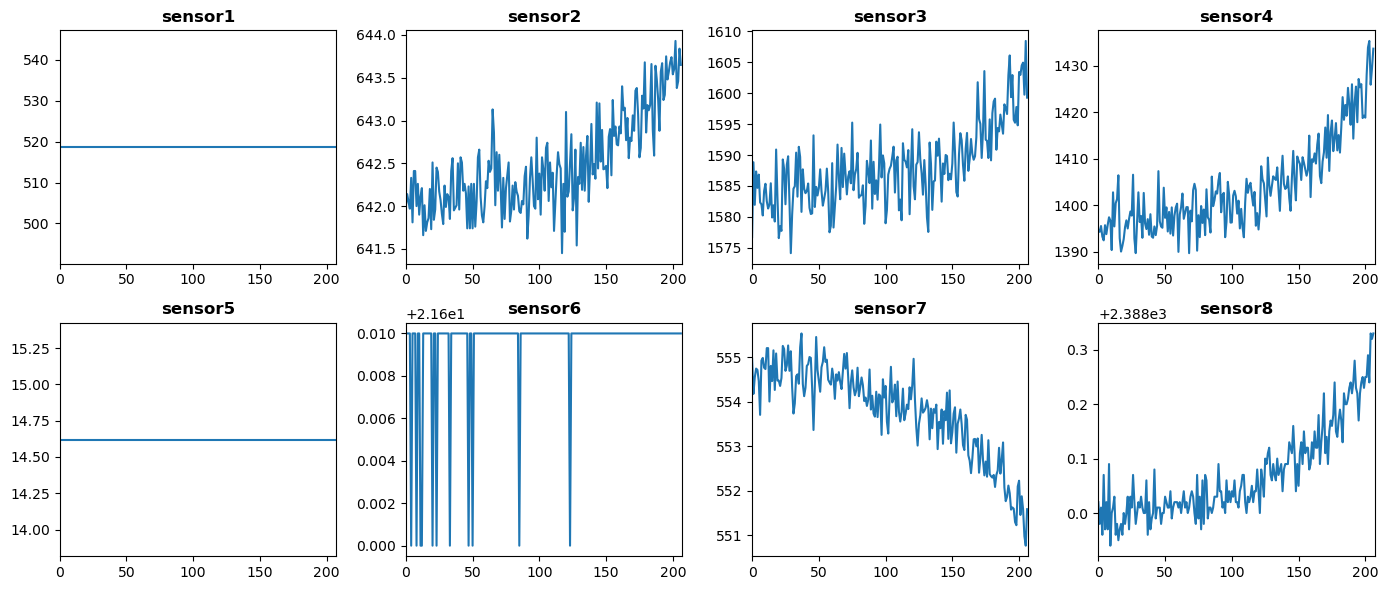

In [29]:
%matplotlib inline
sqlQuery = """
    SELECT  cycle_time, sensor1, sensor2, sensor3, sensor4, sensor5, sensor6, sensor7, sensor8,sensor9,sensor10
    FROM df1 
    WHERE engine =15
    """

plotdata1 = get_pandasdf_from_sparkdf(train_df, "df1", sqlQuery)

plot_pandas_ts(plotdata1, 'cycle_time',  1, 2, 4, 14, 6)

## Ingénierie des caractéristiques 

**Supprimer les caractéristiques à faible variance**  
Nous remarquons, à partir des visualisations ci-dessus, que nos ensembles de données contiennent des caractéristiques constantes qui ne changent pas au fil du temps. Ce type de caractéristiques est inutile pour construire des modèles de données prédictifs. Par conséquent, nous supprimons ces caractéristiques de nos ensembles de données.

In [60]:
%%time
def spark_remove_low_var_features(spark_df, features, threshold, remove):
 
    low_var_features = []
    
    # creer la list des valeurs low
    low_var_values = []
    
    for f in features:
        std = float(spark_df.describe(f).filter("summary = 'stddev'").select(f).collect()[0].asDict()[f])
        
        # la variance
        var = std*std

        if var <= threshold:
            
            low_var_features.append(f)
            low_var_values.append(var)
            
            print(f + ': var: ' + str(var))
            
            if remove:
                spark_df = spark_df.drop(f)
    
    return spark_df, low_var_features, low_var_values

non_features_cols = ['engine', 'cycle_time', 'rul','classification']

data_features = set(train_df.columns) - set(non_features_cols)

train_df, train_low_var_features, train_low_var_values = spark_remove_low_var_features(train_df, data_features, 0.05, False)
test_df, test_low_var_features, test_low_var_values = spark_remove_low_var_features(test_df, data_features, 0.05, False)

for f in sorted(list(set().union(train_low_var_features,test_low_var_features))):    
    train_df = train_df.drop(f)
    test_df = test_df.drop(f)


sensor19: var: 0.0
sensor18: var: 0.0
sensor15: var: 0.001406627871778399
sensor6: var: 1.9292790877315946e-06
operational_set_1: var: 4.784340124242534e-06
sensor16: var: 0.0
sensor13: var: 0.005172330435114698
sensor8: var: 0.00503893821332172
sensor1: var: 0.0
sensor20: var: 0.032669271189087544
operational_set_3: var: 0.0
operational_set_2: var: 8.58854088552227e-08
sensor10: var: 0.0
sensor21: var: 0.011718251883038811
sensor5: var: 0.0
sensor19: var: 0.0
sensor18: var: 0.0
sensor15: var: 0.0008415410846462574
sensor6: var: 2.9039048558087206e-06
operational_set_1: var: 4.8518215652124385e-06
sensor16: var: 0.0
sensor13: var: 0.003241515691946351
sensor8: var: 0.00329955856558659
sensor1: var: 0.0
sensor20: var: 0.020073436423782218
operational_set_3: var: 0.0
operational_set_2: var: 8.645397438669501e-08
sensor10: var: 0.0
sensor11: var: 0.03838356701111794
sensor21: var: 0.007076221533459848
sensor5: var: 0.0
CPU times: total: 641 ms
Wall time: 5min 27s


In [61]:
(train_df.count(), len(train_df.columns)),(test_df.count(), len(test_df.columns))

((20631, 12), (13096, 12))

## Supprimer le noise (le bruit)

In [62]:
%%time
def add_rolling_avg_features(df, features, lags, idx, time):
  
    for lag_n in lags:
        
        w = Window.partitionBy(idx).orderBy(time).rowsBetween(1-lag_n, 0)
        
        for f in features:
            
            df = df.withColumn(f + '_rollingmean_'+str(lag_n), F.avg(F.col(f)).over(w))
    
    return df

data_features = set(train_df.columns) - set(non_features_cols)
lags = [4]

train_df = add_rolling_avg_features(train_df, data_features, lags, "engine", "cycle_time")
test_df = add_rolling_avg_features(test_df, data_features, lags, "engine", "cycle_time")

CPU times: total: 31.2 ms
Wall time: 599 ms


In [63]:
(train_df.count(), len(train_df.columns)),(test_df.count(), len(test_df.columns))

((20631, 20), (13096, 20))

In [64]:
train_df.show()

+------+----------+-------+-------+-------+-------+-------+--------+--------+--------+---+--------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+----------------------+
|engine|cycle_time|sensor2|sensor3|sensor4|sensor7|sensor9|sensor12|sensor14|sensor17|rul|classification|sensor9_rollingmean_4|sensor3_rollingmean_4|sensor17_rollingmean_4|sensor2_rollingmean_4|sensor4_rollingmean_4|sensor7_rollingmean_4|sensor14_rollingmean_4|sensor12_rollingmean_4|
+------+----------+-------+-------+-------+-------+-------+--------+--------+--------+---+--------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+----------------------+
|     1|         1| 641.82| 1589.7| 1400.6| 554.36|9046.19|  521.66| 8138.62|   392.0| 98|             0|              9046.19|               158

### Normalisation

In [65]:
roll_data_features = [s for s in set(train_df.columns) if (s.endswith("rollingmean_4"))]
roll_data_features

['sensor7_rollingmean_4',
 'sensor3_rollingmean_4',
 'sensor2_rollingmean_4',
 'sensor17_rollingmean_4',
 'sensor9_rollingmean_4',
 'sensor14_rollingmean_4',
 'sensor12_rollingmean_4',
 'sensor4_rollingmean_4']

In [66]:
def Normalisation(df, features):
   
    w = Window.partitionBy("engine")
    
    for f in features:               
        norm_feature = (F.col(f) - F.min(f).over(w)) / (F.max(f).over(w) - F.min(f).over(w))
        df = df.withColumn(f + '_norm', norm_feature) 

    return df

train_df = Normalisation(train_df, roll_data_features)
test_df = Normalisation(test_df, roll_data_features)

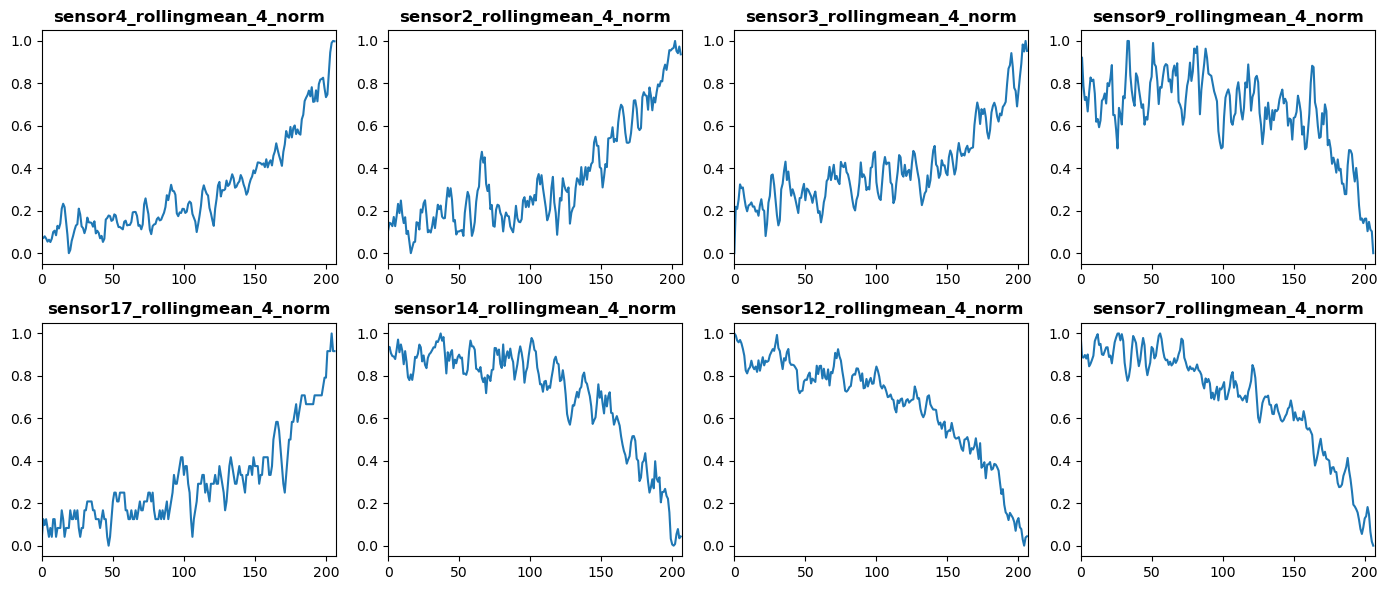

In [71]:
norm_roll_data_features = [s for s in set(train_df.columns) if (s.endswith("_norm"))]
columns_to_select = ", ".join(["cycle_time"] + norm_roll_data_features)  
sqlQuery3 = f"SELECT {columns_to_select} FROM df1 WHERE df1.engine=15 ORDER BY df1.cycle_time"


plotdata1 = get_pandasdf_from_sparkdf(train_df, "df1", sqlQuery3)

plot_pandas_ts(plotdata1, 'cycle_time', 1, 2, 4, 14, 6)

In [72]:
norm_roll_data_features

['sensor4_rollingmean_4_norm',
 'sensor2_rollingmean_4_norm',
 'sensor3_rollingmean_4_norm',
 'sensor9_rollingmean_4_norm',
 'sensor17_rollingmean_4_norm',
 'sensor14_rollingmean_4_norm',
 'sensor12_rollingmean_4_norm',
 'sensor7_rollingmean_4_norm']

### Correlation

In [ ]:
%%time
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import operator

def get_correlations(df, features):
    
    vector_col = "corr_features"
    assembler = VectorAssembler(inputCols= features, outputCol=vector_col)
    df_vector = assembler.transform(df).select(vector_col)

    r1 = Correlation.corr(df_vector, vector_col).head()

    corr_list = r1[0].toArray()[:1,:].tolist()[0]

    corr_dict = dict(zip(corr_list, input_features))

    sorted_corr_dict = sorted(corr_dict.items(), key=operator.itemgetter(0))
    
    return sorted_corr_dict

index_features = ["engine", "cycle_time", "classification",  "rul"]

numerical_features = list(set(train_df.columns) - set(index_features))

input_features = ["rul"] + numerical_features

train_ulr_corr = get_correlations(train_df, input_features)
test_ulr_corr = get_correlations(test_df, input_features)

print("Top Positive Correlated Features (Train):\n") 
for i in reversed(train_ulr_corr[-6:-1]):    
    print(i)

print("\nTop Positive Correlated Features (Test):\n") 
for i in reversed(test_ulr_corr[-6:-1]):    
    print(i)
    
print("\nTop Negative Correlated Features (Train):\n") 
for i in train_ulr_corr[0:5]:    
    print(i)
    
print("\nTop Negative Correlated Features (Test):\n") 
for i in test_ulr_corr[0:5]:    
    print(i)

Top Positive Correlated Features (Train):

(0.7780036588283887, 'sensor12_rollingmean_4_norm')
(0.756014710663776, 'sensor7_rollingmean_4_norm')
(0.6485912839374742, 'sensor12_rollingmean_4')
(0.6444740767079123, 'sensor7_rollingmean_4')
(0.6113536330275836, 'sensor12')

Top Positive Correlated Features (Test):

(0.46965591354974784, 'sensor12_rollingmean_4_norm')
(0.4362183142697381, 'sensor7_rollingmean_4_norm')
(0.28174730526354896, 'sensor12_rollingmean_4')
(0.2793275065017528, 'sensor7_rollingmean_4')
(0.25357957549938526, 'sensor12')

Top Negative Correlated Features (Train):

(-0.7724622783439339, 'sensor4_rollingmean_4_norm')
(-0.7258186555209443, 'sensor2_rollingmean_4_norm')
(-0.7245290434612344, 'sensor17_rollingmean_4_norm')
(-0.7056922820964877, 'sensor3_rollingmean_4_norm')
(-0.673272585201146, 'sensor4_rollingmean_4')

Top Negative Correlated Features (Test):

(-0.4495997897300632, 'sensor4_rollingmean_4_norm')
(-0.3857527762956402, 'sensor17_rollingmean_4_norm')
(-0.383

### Enregitrer la data 

In [81]:

output_dir = os.path.join(os.getcwd(), "data")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

    
output_path = os.path.join(output_dir, "train_preprocessed.parquet")
output_path_test = os.path.join(output_dir, "test_preprocessed.parquet")
# final_df.write.mode("overwrite").csv("data/train_preprocessed.csv")
# final_test_df.write.mode("overwrite").parquet(output_path_test)


In [82]:
%%time
pandas_df = train_df.toPandas()
pandas_df_test =test_df.toPandas()

pandas_df.to_csv("data/train_preprocessed.csv", index=False)

pandas_df_test.to_csv("data/test_preprocessed.csv", index=False)


CPU times: total: 2.69 s
Wall time: 5.11 s
